# Basic Interferometry: Tracing a Signal

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Interferometry is the practice of using multiple antennas in a radio telescope array to observe astronomical sources. In this notebook we will look at a two-element interferomter and trace the path of the signal it recieves from two sources, A and B.

<img src="interferometer.png" alt="Drawing" style="width: 300px;"/>

We will assume that A and B both emit some gaussian random signal:

In [11]:
SIZE = 10000
t = np.arange(SIZE) * 0.5e-9 # time step of 0.5 us = 1/(2 MHz)
e_A = np.random.normal(size=SIZE)
e_B = 0.5 * np.random.normal(size=SIZE)

In [12]:
print(np.average(e_A * e_B), np.average(e_A*e_A), np.average(e_B*e_B))

0.0033217877976456605 1.0314091803155911 0.24828554360715638


## Geometric Delay

Since the dishes are not exactly the same distance from each source, there will be some time delay between when a signal reaches antenna 1 and antenna 2. This is known as the _geometric delay_ and is typically denoted $\tau$. Here $\tau_A$ and $\tau_B$ are the geometric delays for signals from A and B to reach antenna 2 relative to antenna 1.

Recall that a shift can be regarded as a convolution with a delta function and by the Convolution Theorem: $ f * g = \mathcal{F}^{-1}[\mathcal{F}(f) \cdot \mathcal{F}(g)] $.

### $e_{A_{dly}}(t) \equiv e_A(t-\tau_A) = \mathcal{F}^{-1}\left[\mathcal{F}[e_A(t)] \cdot e^{2i\pi \tau_A\nu}\right]$
### $e_{B_{dly}}(t) \equiv e_B(t-\tau_B) = \mathcal{F}^{-1}\left[\mathcal{F}[e_B(t)] \cdot e^{2i\pi \tau_B\nu}\right]$

In [13]:
fqs = np.fft.fftfreq(t.size, np.median(np.diff(t)))
tau_A = 2e-9
tau_B = -30e-9
e_A_dly = np.fft.ifft(np.fft.fft(e_A) * np.exp(2j*np.pi*tau_A*fqs))
e_B_dly = np.fft.ifft(np.fft.fft(e_B) * np.exp(2j*np.pi*tau_B*fqs))

In [14]:
plt.plot(t * 1e9, e_A, label=r"$e_A(t)$")
plt.plot(t * 1e9, e_A_dly, label=r"$e_{A_{dly}}(t)$")
plt.title("Delayed Signal vs Original")
plt.ylabel('Electric Field')
plt.xlabel('Time [ns]')
plt.xlim(0,150)
plt.legend()

The voltage response at an antenna comes from the sum of the electromagnetic signals it recieves.

### $v_1(t) \equiv e_A(t) + e_B(t)$ 
### $v_2(t) \equiv e_A(t - \tau_A) + e_B(t - \tau_B)$

In [15]:
v1 = e_A_dly + e_B_dly
v2 = e_A + e_B

## Correlation and Visibility

Now, how can we isolate a signal from a particular source when all we have are the voltages at each antenna? We use the correlation! Independent signals will be uncorrelated with each other, but time offset versions of the same signal will be correlated. 

First however we will look at another quantity that is often used in interferometry, the _visibility_ $V_{12}(\nu)$. 

### $V_{12}(\nu) \equiv \mathcal{F}(v_1(t)) \cdot \mathcal{F}(v_2^*(t))$

There are a few interpretations of what the visibility represents. One is that by the Correlation Theorem you can see that the visibility is the Fourier Transform of the correlation.

In [16]:
V12 = np.fft.fft(v1) * np.conj(np.fft.fft(v2))

<IPython.core.display.Javascript object>


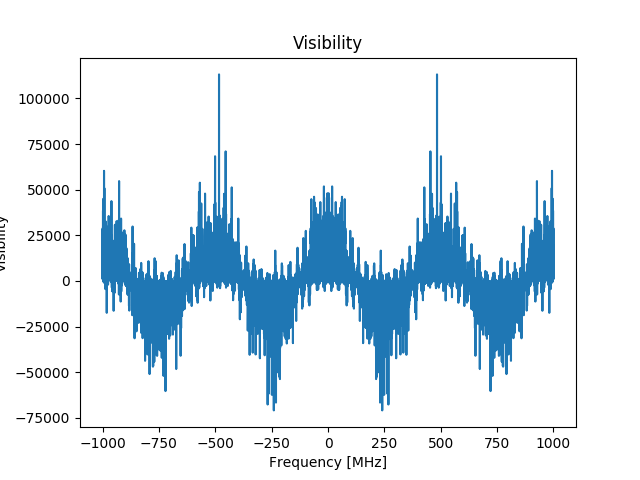

Text(0.5, 0, 'Frequency [MHz]')

In [17]:
plt.figure()
plt.plot(np.fft.fftshift(fqs) / 1e6, np.fft.fftshift(V12))
plt.title("Visibility")
plt.ylabel('Visibility')
plt.xlabel('Frequency [MHz]')



### $[v_1 \star v_2] (\tau) = \int v_1(t) v_2^*(t-\tau) dt = \int [e_A(t) + e_B(t)]\cdot[e_A(t - \tau_A - \tau) + e_B(t - \tau_B -\tau)]^* dt$

Since our signals are all real we can drop the complex conjugate and expand:

### $ = \int \left[e_A(t) \cdot e_A(t - \tau_A - \tau) + e_A(t) \cdot e_B(t - \tau_B - \tau) + e_B(t) \cdot e_A(t - \tau_A - \tau) + e_B(t) \cdot e_B(t - \tau_B - \tau)\right] dt$

Since $e_A$ and $e_B$ are independent of each other the second and third terms integrate to zero.

### $[v_1 \star v_2] (\tau) = \int \left[e_A(t) \cdot e_A(t - \tau_A - \tau) + e_B(t) \cdot e_B(t - \tau_B - \tau)\right] dt$

Since each signal is also composed of independent random values, the autocorrelation should integrate down to zero unless $\tau=-\tau_A$ or $\tau=-\tau_B$.

### $[v_1 \star v_2] (\tau) = \langle e_A^2\rangle \cdot I(\tau=-\tau_A) + \langle e_A^2\rangle \cdot I(\tau=-\tau_B)$

Where $I(x)$ is the indicator function that is 1 when $x$ is true and 0 otherwise.

<IPython.core.display.Javascript object>


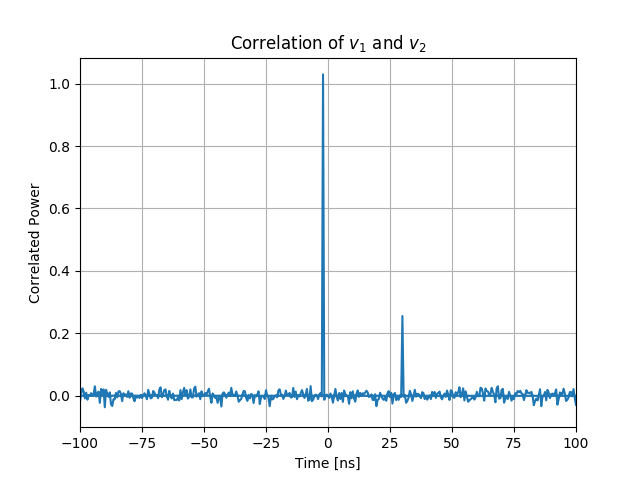

In [18]:
taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])
plt.figure()
plt.plot(taus * 1e9, np.fft.ifft(V12) / SIZE)
plt.title('Correlation of $v_1$ and $v_2$')
plt.ylabel('Correlated Power')
plt.xlabel('Time [ns]')
plt.xlim(-100, 100)
plt.grid()